In [1]:
import abc
import logging
import os
import re
from typing import Callable

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
from samitorch.inputs.transformers import ToNumpyArray
from torchvision.transforms import transforms

In [2]:
class AbstractPreProcessingPipeline(metaclass=abc.ABCMeta):
    """
    Define a preprocessing pipeline.
    """

    @staticmethod
    def _get_image_affine(file):
        return nib.load(file).affine

    @staticmethod
    def _get_image_header(file):
        return nib.load(file).header

    @abc.abstractmethod
    def run(self, **kwargs):
        """
        Run the preprocessing pipeline.
        Args:
            **kwargs: Optional keyword arguments.
        """
        raise NotImplementedError

In [3]:
class ISEGImageExtraction(AbstractPreProcessingPipeline):
    LOGGER = logging.getLogger("DataMining")

    def __init__(self, root_dir: str):
        self._root_dir = root_dir
        self._transforms = transforms.Compose([ToNumpyArray()])
    
    def run(self, prefix=""):
        images_np = list()
        seg_np = list()
        EXCLUDED = ["ROI", "label", "Normalized"]

        for root, dirs, files in os.walk(os.path.join(self._root_dir)):
            if os.path.basename(os.path.normpath(root)) in EXCLUDED:
                continue

            images = list(filter(re.compile(r".*T.*\.nii").search, files))
            for file in images:
                try:
                    self.LOGGER.info("Processing: {}".format(file))
                
                    images_np.append(self._transforms(os.path.join(root, file)))

                except Exception as e:
                    self.LOGGER.warning(e)
                    
        for root, dirs, files in os.walk(os.path.join(self._root_dir, "label")):
             for file in files:
                try:
                    seg_np.append(self._transforms(os.path.join(root, file)))
                except Exception as e:
                    self.LOGGER.warning(e)

        images = np.array(images_np).astype(np.float32)
        seg_np = np.array(seg_np).astype(np.float32)

        return images, seg_np
        

In [6]:
class MRBrainSImageExtraction(AbstractPreProcessingPipeline):
    LOGGER = logging.getLogger("PreProcessingPipeline")

    def __init__(self, root_dir):
        self._root_dir = root_dir
        self._transforms = transforms.Compose([ToNumpyArray()])


    def run(self, prefix="scaled_"):
        images_np = list()
        seg_map_np = list()

        for root, dirs, files in os.walk(os.path.join(self._root_dir)):
            images = list(filter(re.compile(r"^T.*\.nii").search, files))
            
            for file in images:
                try:
                    self.LOGGER.info("Processing: {}".format(file))
                    images_np.append(self._transforms(os.path.join(root, file)))
                    
                except Exception as e:
                    self.LOGGER.warning(e)
        
        for root, dirs, files in os.walk(os.path.join(self._root_dir)):
            labels = list(filter(re.compile(r"^LabelsForTesting.*\.nii").search, files))

            for file in labels:
                seg_map_np.append(self._transforms(os.path.join(root, file)))

        images = np.array(images_np).astype(np.float32)
        segmentation = np.array(seg_map_np).astype(np.float32)
    
        return images, segmentation

In [7]:
mrbrains_path = "/Users/pierre-luc-delisle/Documents/data/MRBrainS/Normalized"
iseg_path = "/Users/pierre-luc-delisle/Documents/data/iSEG/Normalized"
iseg_images, iseg_seg = ISEGImageExtraction(iseg_path).run()
mrbrains_images, mrbrains_seg = MRBrainSImageExtraction(mrbrains_path).run()

NameError: name 'transforms' is not defined

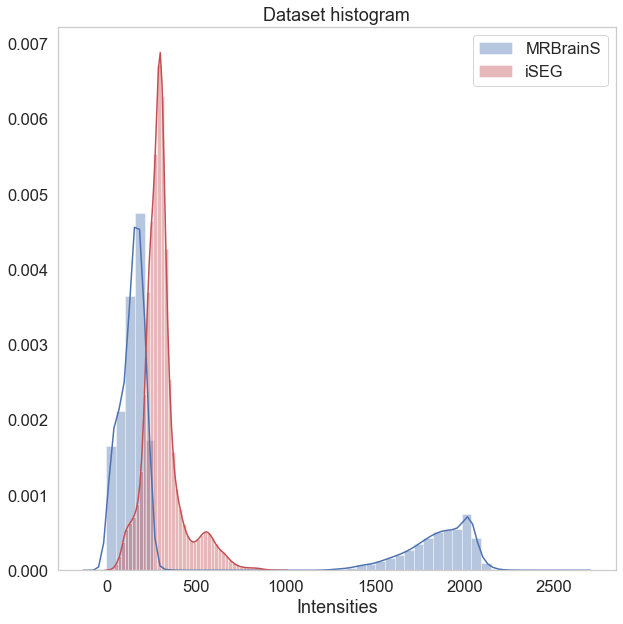

In [6]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.subplots(figsize=(10,10))
sns.distplot(mrbrains_images.flatten()[np.nonzero(mrbrains_images.flatten())], hist=True, norm_hist=True, kde=True, color="b", label="MRBrainS", axlabel="Intensities").set_title("Dataset histogram")
ax = sns.distplot(iseg_images.flatten()[np.nonzero(iseg_images.flatten())], hist=True, norm_hist=True, kde=True, color="r", label="iSEG")

            
plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Intensities_10x10.png")

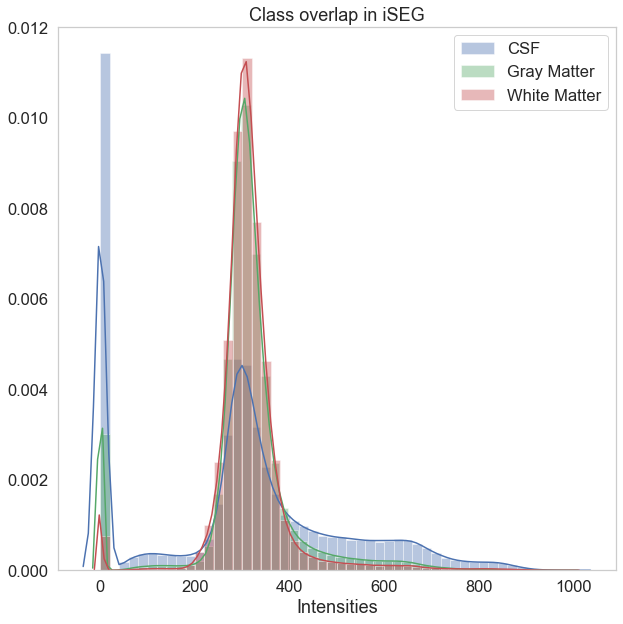

In [7]:
plt.subplots(figsize=(10,10))
sns.distplot(iseg_images[np.where(iseg_seg==1)], hist=True, norm_hist=True, kde=True, color="b", label="CSF",  axlabel="Intensities").set_title("Class overlap in iSEG")
sns.distplot(iseg_images[np.where(iseg_seg==2)], hist=True, norm_hist=True, kde=True, color="g", label="Gray Matter")
ax = sns.distplot(iseg_images[np.where(iseg_seg==3)], hist=True, norm_hist=True, kde=True, color="r", label="White Matter")
plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap iSEG_10x10.png")

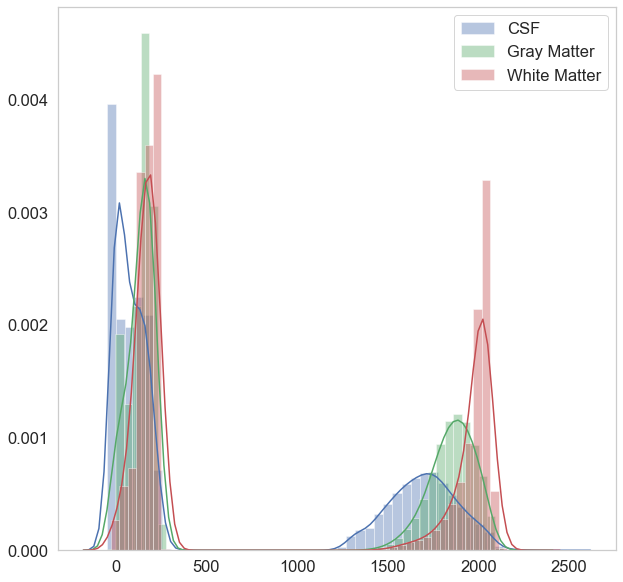

In [8]:
plt.subplots(figsize=(10,10))
sns.distplot(mrbrains_images[np.where(mrbrains_seg==1)], hist=True, norm_hist=False, kde=True, color="b", label="CSF")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==2)], hist=True, norm_hist=False, kde=True, color="g", label="Gray Matter")
ax = sns.distplot(mrbrains_images[np.where(mrbrains_seg==3)], hist=True, norm_hist=False, kde=True, color="r", label="White Matter")
ax.set_title("MRBrainS Intensity Distribution")
ax.set_ylabel("Voxel count")
ax.set_xlabel("Intensities")
plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap MRBrainS_10x10.png")

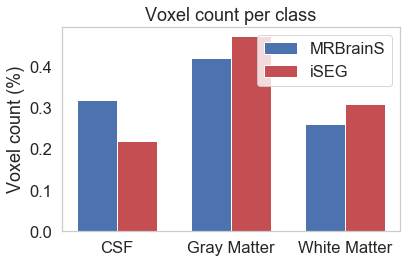

In [9]:
width = 0.35  # the width of the bars
labels = ["CSF", "Gray Matter", "White Matter"]
x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()

total_mrbrains = np.unique(mrbrains_seg, return_counts=True)[1][1:4].sum()
total_iseg = np.unique(iseg_seg, return_counts=True)[1][1:4].sum()
rects1 = ax.bar(x-width/2, np.unique(mrbrains_seg, return_counts=True)[1][1:4]/total_mrbrains, width, label="MRBrainS", color='b')
rects2 = ax.bar(x+width/2, np.unique(iseg_seg, return_counts=True)[1][1:4]/total_iseg, width, label="iSEG", color='r')
ax.set_ylabel('Voxel count (%)')
ax.set_title('Voxel count per class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()
fig.savefig("Voxel count.png")

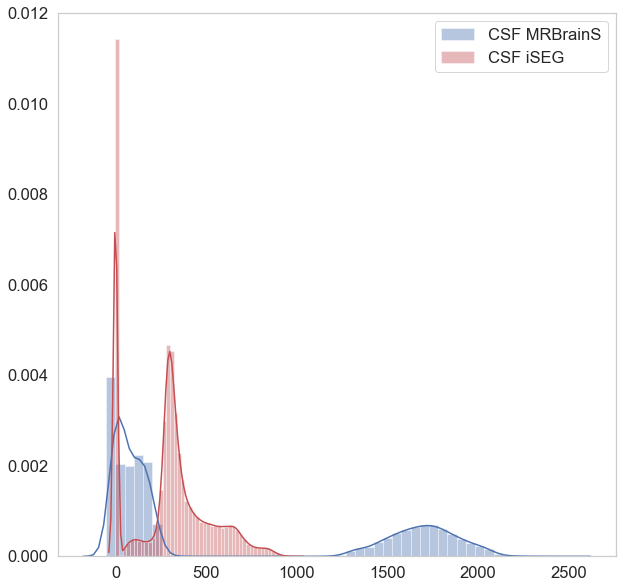

In [10]:
plt.subplots(figsize=(10,10))
sns.distplot(mrbrains_images[np.where(mrbrains_seg==1)], hist=True, norm_hist=True, kde=True, color="b", label="CSF MRBrainS")
ax = sns.distplot(iseg_images[np.where(iseg_seg==1)], hist=True, norm_hist=True, kde=True, color="r", label="CSF iSEG")

plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap class1_10x10.png")

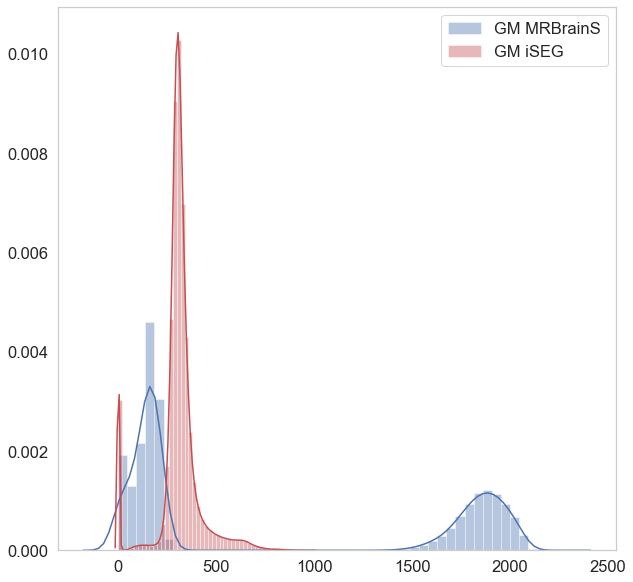

In [11]:
plt.subplots(figsize=(10,10))
sns.distplot(mrbrains_images[np.where(mrbrains_seg==2)], hist=True, norm_hist=True, kde=True, color="b", label="GM MRBrainS")
ax = sns.distplot(iseg_images[np.where(iseg_seg==2)], hist=True, norm_hist=True, kde=True, color="r", label="GM iSEG")

plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap class2_10x10.png")

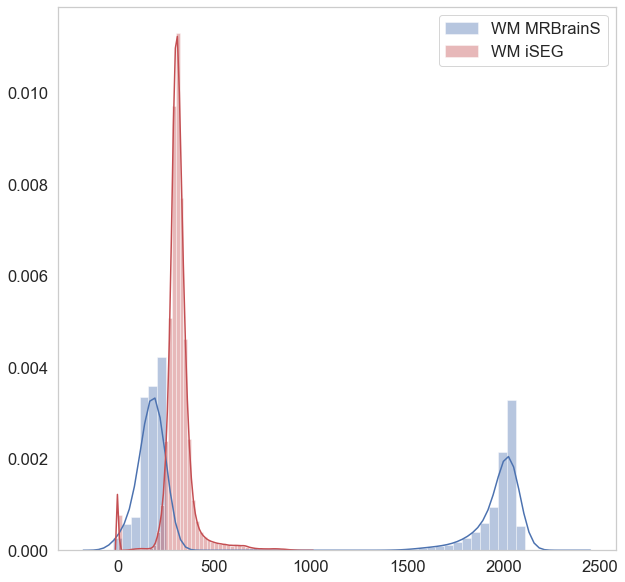

In [12]:
plt.subplots(figsize=(10,10))
sns.distplot(mrbrains_images[np.where(mrbrains_seg==3)], hist=True, norm_hist=True, kde=True, color="b", label="WM MRBrainS")
ax = sns.distplot(iseg_images[np.where(iseg_seg==3)], hist=True, norm_hist=True, kde=True, color="r", label="WM iSEG")
plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap class3_10x10.png")

In [16]:
red_1 = sns.color_palette("RdBu", n_colors=8)[0]
red_2 = sns.color_palette("RdBu", n_colors=8)[2]
blue_1 = sns.color_palette("RdBu", n_colors=8)[7]
blue_2 = sns.color_palette("RdBu", n_colors=8)[5]
green_1 = sns.color_palette("Greens_r", n_colors=8)[0]
green_2 = sns.color_palette("Greens_r", n_colors=8)[4]

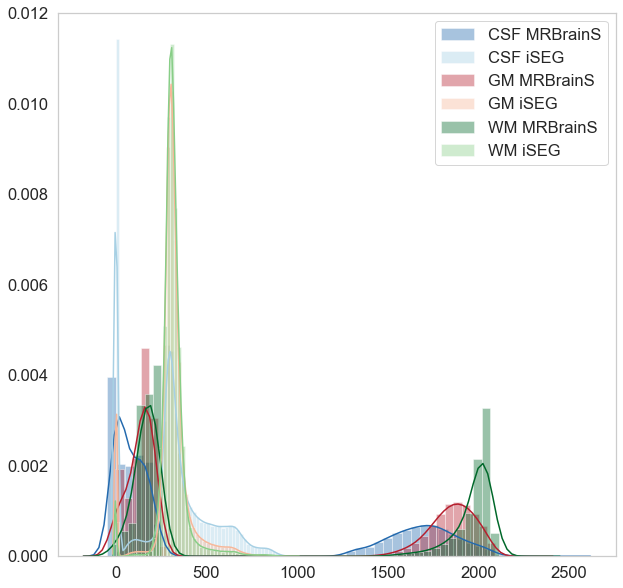

In [14]:
plt.subplots(figsize=(10,10))
sns.color_palette("muted")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==1)], hist=True, norm_hist=True, kde=True, color=blue_1, label="CSF MRBrainS")
sns.distplot(iseg_images[np.where(iseg_seg==1)], hist=True, norm_hist=True, kde=True, color=blue_2, label="CSF iSEG")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==2)], hist=True, norm_hist=True, color=red_1, kde=True, label="GM MRBrainS")
sns.distplot(iseg_images[np.where(iseg_seg==2)], hist=True, norm_hist=True, kde=True,  color=red_2, label="GM iSEG")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==3)], hist=True, norm_hist=True, kde=True, color=green_1, label="WM MRBrainS")
ax = sns.distplot(iseg_images[np.where(iseg_seg==3)], hist=True, norm_hist=True, kde=True, color=green_2, label="WM iSEG")

plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap all_10x10.png")

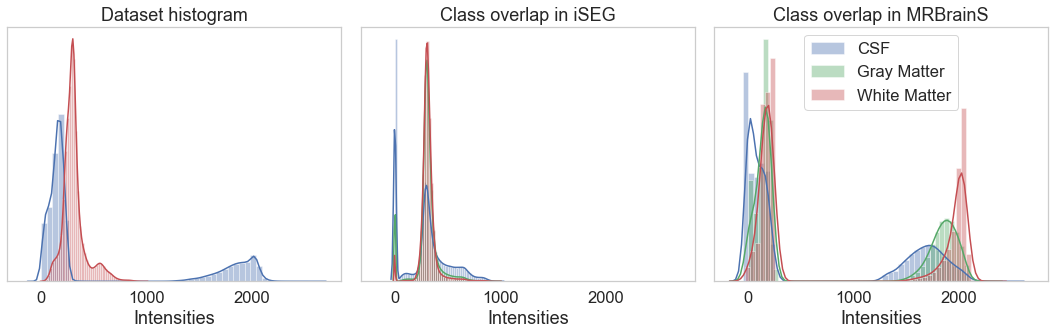

In [15]:
f, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True)

sns.distplot(mrbrains_images.flatten()[np.nonzero(mrbrains_images.flatten())], hist=True, norm_hist=True, kde=True, color="b", label="MRBrainS", axlabel="Intensities", ax=axes[0]).set_title("Dataset histogram")
sns.distplot(iseg_images.flatten()[np.nonzero(iseg_images.flatten())], hist=True, norm_hist=True, kde=True, color="r", label="iSEG", ax=axes[0])

sns.distplot(iseg_images[np.where(iseg_seg==1)], hist=True, norm_hist=True, kde=True, color="b", label="CSF",  axlabel="Intensities", ax=axes[1]).set_title("Class overlap in iSEG")
sns.distplot(iseg_images[np.where(iseg_seg==2)], hist=True, norm_hist=True, kde=True, color="g", label="Gray Matter", ax=axes[1])
sns.distplot(iseg_images[np.where(iseg_seg==3)], hist=True, norm_hist=True, kde=True, color="r", label="White Matter", ax=axes[1])

sns.distplot(mrbrains_images[np.where(mrbrains_seg==1)], hist=True, norm_hist=True, kde=True, color="b", label="CSF", axlabel="Intensities", ax=axes[2]).set_title("Class overlap in MRBrainS")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==2)], hist=True, norm_hist=True, kde=True, color="g", label="Gray Matter", ax=axes[2])
sns.distplot(mrbrains_images[np.where(mrbrains_seg==3)], hist=True, norm_hist=True, kde=True, color="r", label="White Matter", ax=axes[2])

plt.legend()

plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

In [7]:
nb_voxels_class_0 = np.count_nonzero(iseg_images[np.where(iseg_seg==0)]) + np.count_nonzero(mrbrains_images[np.where(mrbrains_seg==0)])
nb_voxels_class_1 = np.count_nonzero(iseg_images[np.where(iseg_seg==1)]) + np.count_nonzero(mrbrains_images[np.where(mrbrains_seg==1)])
nb_voxels_class_2 = np.count_nonzero(iseg_images[np.where(iseg_seg==2)]) + np.count_nonzero(mrbrains_images[np.where(mrbrains_seg==2)])
nb_voxels_class_3 = np.count_nonzero(iseg_images[np.where(iseg_seg==3)]) + np.count_nonzero(mrbrains_images[np.where(mrbrains_seg==3)])

print(nb_voxels_class_1)
total = nb_voxels_class_0 + nb_voxels_class_1 + nb_voxels_class_2 + nb_voxels_class_3

weights = [nb_voxels_class_0/total, nb_voxels_class_1 / total, nb_voxels_class_2 / total, nb_voxels_class_3 / total]
print(weights)
print(weights[0] + weights[1] + weights[2])
total = nb_voxels_class_1 + nb_voxels_class_2 + nb_voxels_class_3
weights = [nb_voxels_class_1 / total, nb_voxels_class_2 / total, nb_voxels_class_3 / total]
print(weights)

2982740
[0.0750852738049003, 0.2098593967230093, 0.4291910808665845, 0.2858642486055059]
0.7141357513944941
[0.22689594054397397, 0.46403313593263273, 0.3090709235233933]
